<a href="https://colab.research.google.com/github/Samtomsa/DSF/blob/main/MidTerm%20Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MidTerm Project ** Tutorial performing: https://projects.volkamerlab.org/teachopencadd/talktorials/T022_ligand_based_screening_neural_network.html



**Libraries**

In [24]:
#import all the necessary libraries

!pip install rdkit-pypi
from rdkit import Chem
from rdkit.Chem import AllChem
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Data preparation**
Use CHEMBL-ID, SMILES, pIC50 (von IC50)

In [27]:
#connect drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [29]:
#Load dataset 
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kinase.csv', index_col=0)
df = df.reset_index(drop=True)

In [30]:
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (179827, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179827 entries, 0 to 179826
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   molecule_chembl_id  179827 non-null  object 
 1   standard_value      179827 non-null  float64
 2   standard_units      179827 non-null  object 
 3   target_chembl_id    179827 non-null  object 
 4   smiles              179827 non-null  object 
dtypes: float64(1), object(4)
memory usage: 6.9+ MB


In [ ]:
# Look at head
df.head()

,Unnamed: 0,molecule_chembl_id,standard_value,standard_units,target_chembl_id,smiles
0,0,CHEMBL13462,4000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,1,CHEMBL13462,16000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
2,2,CHEMBL13462,800.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,3,CHEMBL13462,9000.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
4,4,CHEMBL13462,1700.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...


In [33]:
# Convert IC50 to pIC50 (standart_value to the pIC50)
df['pIC50'] = np.log10(df['standard_value'])

# Print the first few rows of the updated dataframe
df.head()

,molecule_chembl_id,standard_value,standard_units,target_chembl_id,smiles,pIC50
0,CHEMBL13462,4000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,3.602060
1,CHEMBL13462,16000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,4.204120
2,CHEMBL13462,800.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,2.903090
3,CHEMBL13462,9000.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,3.954243
4,CHEMBL13462,1700.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,3.230449


In [43]:
chembl_df = df[["smiles","pIC50"]]
chembl_df.head()

,smiles,pIC50
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,3.602060
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,4.204120
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,2.903090
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,3.954243
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,3.230449


In [44]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

Convert all SMILES strings to MACCS fingerprints

In [46]:
chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (179827, 3)


,smiles,pIC50,fingerprints_df
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,3.60206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,4.20412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,2.90309,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Define x (Features) and y (target data)

In [47]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)

Shape of training data: (125878,)
Shape of test data: (53949,)


Define neutral network

In [48]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

Train the model

In [49]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

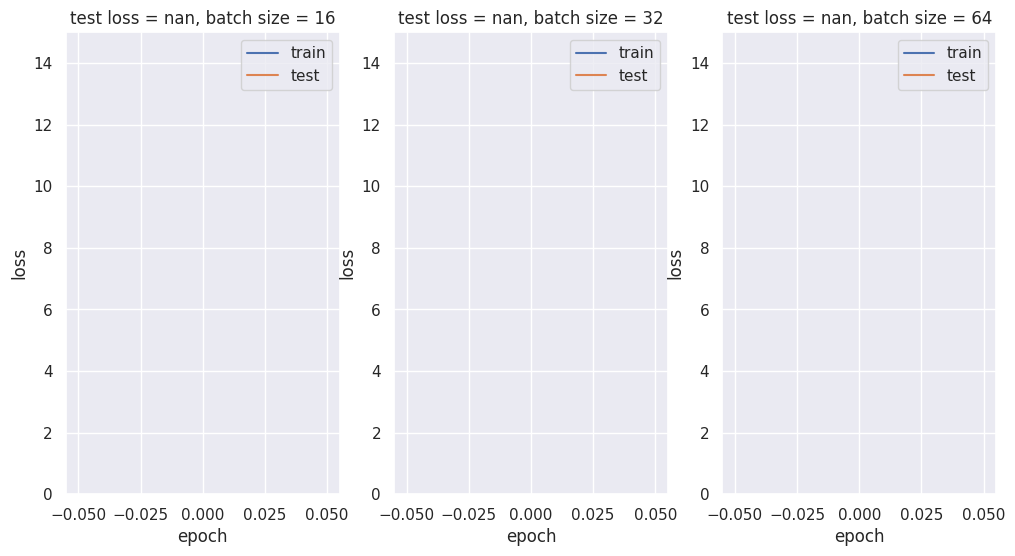

In [50]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}")
plt.show()

ModelCheckoint callback, save trained model

In [51]:
# Set the path to the folder where the weights will be saved
weights_folder = "/content/drive/MyDrive/Colab Notebooks/"

# Save the trained model
filepath = os.path.join(weights_folder, "best_weights.hdf5")
checkpoint = ModelCheckpoint(
    filepath,
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

In [ ]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 315157049769984.00
 mse (same as loss): 315157049769984.00
 mae: 131751.84


In [ ]:
# Predict standard_value values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first standard_value predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

1686/1686 [==============================] - 3s 2ms/step
12.40
12.40
12.40
12.40
12.40


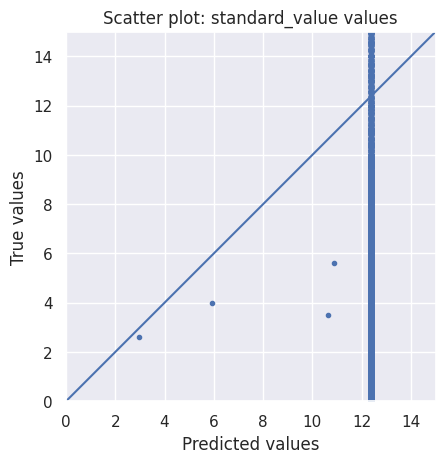

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: standard_value values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()